### 回す用のプログラム

In [1]:
import subprocess
import os
import pandas as pd
import re
import nltk
import numpy as np
import csv
import itertools
import math
from csv import reader
from math import log
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
os.getcwd()

'/Users/yuna-s/SocSEL/test'

### 変数宣言

In [3]:
repo_name = 'nativescript-mpchart'  # あらかじめ対象リポジトリをクローンしておく
target_dir = f'/Users/yuna-s/SocSEL/analysis' # 対象リポジトリが存在するファイルパス．
commit_num = 10 # 前後Nコミットを指定
target_commit_hash_list = [] # 前後Nコミットのハッシュ値リスト保存用

In [4]:
os.chdir(f'{target_dir}/{repo_name}')

In [5]:
os.getcwd()

'/Users/yuna-s/SocSEL/analysis/nativescript-mpchart'

### 対象リポジトリのハッシュ値をcsvファイルとして取得

In [6]:
# コミットのハッシュ値を取得する
def _get_repo_hash(repo_name, target_dir):
    os.chdir(f'{target_dir}/{repo_name}') # gitコマンドを使用するために対象リポジトリのある，ディレクトリへ移動
    hash_save_filepath = f'{target_dir}/{repo_name}/commit_hash.csv' # 保存先のファイルパス
    hash_get_cmd = f"git log | grep -E '^(commit)' | sed 's/commit //' > {hash_save_filepath}" # 実行コマンド
    subprocess.run(hash_get_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, encoding='UTF-8') # 最新順に取得していることに注意

    return 0

In [7]:
# READMEに関するコミットのハッシュ値を取得する
def _get_README_hash(repo_name, target_dir):
    os.chdir(f'{target_dir}/{repo_name}') # gitコマンドを使用するために対象リポジトリのある，ディレクトリへ移動
    hash_save_filepath = f'{target_dir}/{repo_name}/README_commit_hash.csv' # 保存先のファイルパス
    hash_get_cmd = f"git log README.md | grep -E '^(commit)' | sed 's/commit //' > {hash_save_filepath}" # 実行コマンド
    subprocess.run(hash_get_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, encoding='UTF-8') # 最新順に取得していることに注意
    return 0

In [8]:
# 実行

# ハッシュ値をcsvで取得して，リストに入れる
_get_repo_hash(repo_name,target_dir) # 対象リポジトリの全ハッシュ値をcsvファイルとして取得
repo_commit_hash_list = pd.read_csv(f'{target_dir}/{repo_name}/commit_hash.csv', names=['commit_hash'])

# 実行

_get_README_hash(repo_name, target_dir) # 対象リポジトリのREADMEファイルのハッシュ値をcsvファイルとして取得
README_commit_hash_list = pd.read_csv(f'{target_dir}/{repo_name}/README_commit_hash.csv', names=['README_commit_hash'])

In [9]:
# READMEの変更があったコミットのハッシュ値
README_commit_hash_list['README_commit_hash']

0     57fde9c7eda70282d22eedb26591882fc1d1c31d
1     9fc2c32d61efd88d9e0ef672b017f8d4d1e4284c
2     34bad67caa8da2097add8dbb0844758324d7a998
3     de8bf929a40d7cd796a4cd39511577c1c0c1c309
4     4d39d4f88c90155430ae841b1015c23aed43848f
5     504657051d4d928e4c1de699139e71db6f1e862b
6     26629b7592af4be1eac1a275ac3966ddcaa6fb5e
7     845f4212b6a5b8e92d1ad73e0af635b7e837f6f8
8     3c9ff198ed4201bedcb94973f5880ffc5ff34a9a
9     922badc650e84fd07ac8c06b7c04c62ab9330961
10    f62e56273c5170ed55d21623cb7afec32da0036e
Name: README_commit_hash, dtype: object

### READMEのdiffファイルを取得

In [10]:
def _get_README_diff(repo_name, target_dir, README_commit_hash_list):
    os.chdir(f'{target_dir}/{repo_name}') # gitコマンドを使用するために対象リポジトリのある，ディレクトリへ移動

    os.makedirs(f'{target_dir}/{repo_name}/changed_README_per_hash', exist_ok=True)
    os.chdir(f'{target_dir}/{repo_name}') # gitコマンドを使用するために対象プロジェクトのディレクトリへ移動
    changed_README_hash_list = README_commit_hash_list[:-1] # 変更後のコミットハッシュ値リスト
    pre_README_hash_list = README_commit_hash_list[1:] # 変更前のコミットのハッシュ値リスト

    # ファイル出力
    for changed_README_hash, pre_README_hash in zip(changed_README_hash_list['README_commit_hash'], pre_README_hash_list['README_commit_hash']): # 全てのハッシュ値にdiffを適用するために，ループ文を使用する
        save_filepath = f'{target_dir}/{repo_name}/changed_README_per_hash/{changed_README_hash}_default.txt' # 各コミットにおける変更ファイルパスの保存場所
        diff_cmd = f"git diff {pre_README_hash}:README.md {changed_README_hash}:README.md > {save_filepath}" # diffコマンドとgrepコマンドにより，変更されたpythonファイルのみを抽出
        subprocess.run(diff_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, encoding='UTF-8')

    return changed_README_hash_list # READMEの変更コミットのハッシュ値リスト

In [11]:
# READMEの変更コミットのハッシュ値リストと，READMEのdiffを取得(最初のコミットは変更がないので省いている

changed_README_hash_list = _get_README_diff(repo_name, target_dir, README_commit_hash_list)

In [12]:
use_changed_README_hash_list = changed_README_hash_list['README_commit_hash']

In [13]:
print(use_changed_README_hash_list)

0    57fde9c7eda70282d22eedb26591882fc1d1c31d
1    9fc2c32d61efd88d9e0ef672b017f8d4d1e4284c
2    34bad67caa8da2097add8dbb0844758324d7a998
3    de8bf929a40d7cd796a4cd39511577c1c0c1c309
4    4d39d4f88c90155430ae841b1015c23aed43848f
5    504657051d4d928e4c1de699139e71db6f1e862b
6    26629b7592af4be1eac1a275ac3966ddcaa6fb5e
7    845f4212b6a5b8e92d1ad73e0af635b7e837f6f8
8    3c9ff198ed4201bedcb94973f5880ffc5ff34a9a
9    922badc650e84fd07ac8c06b7c04c62ab9330961
Name: README_commit_hash, dtype: object


### README変更前後のハッシュ値リストを取得

In [14]:
# 最終的に対象ハッシュ値を全て格納する多次元リスト
all_target_commit_hash_list = [i for i in range(-commit_num-1, commit_num+1)]

In [15]:
os.chdir(f'{target_dir}/{repo_name}') # gitコマンドを使用するために対象プロジェクトのディレクトリへ移動

with open('practice.csv', 'w') as file:
        writer = csv.writer(file, lineterminator='\n')
        writer.writerow(all_target_commit_hash_list)

In [16]:
# 下のifで，前後Nが全部あることを示すために使う
max_len = len(all_target_commit_hash_list)

In [17]:
# リストを縦に結合するためにarray化
all_target_commit_hash_list = np.array(all_target_commit_hash_list)

In [18]:
# 前後Nコミットのハッシュ値をとるところ
for item in use_changed_README_hash_list:
    target_commit_hash_list = [] # README変更前後のハッシュ値リスト用
    README_changed_rev = repo_commit_hash_list[repo_commit_hash_list['commit_hash'] == item].index[0]

    commit_hash_list_before_README_change = list(repo_commit_hash_list['commit_hash'][README_changed_rev - commit_num:README_changed_rev]) # README変更コミットから，Nコミット前のリスト
    commit_hash_list_after_README_change = list(repo_commit_hash_list['commit_hash'][README_changed_rev+1:README_changed_rev+1+commit_num+1]) # README変更コミットから，Nコミット後のリスト

    target_commit_hash_list.extend(list(reversed(commit_hash_list_after_README_change))) # README変更前後のハッシュ値リストに変更後のハッシュ値リストを追加
    target_commit_hash_list.append(item)      # リストに要素を追加
    target_commit_hash_list.extend(list(reversed(commit_hash_list_before_README_change))) # README変更前後のハッシュ値リストに変更前のハッシュ値リストを追加，リストにリストを追加

    target_commit_hash_list = np.array(target_commit_hash_list)
    if (len(target_commit_hash_list) == max_len):
        all_target_commit_hash_list = np.vstack((all_target_commit_hash_list,target_commit_hash_list))
        with open('practice.csv', 'a') as file:
            writer = csv.writer(file, lineterminator='\n')
            writer.writerow(target_commit_hash_list)


### READMEdiffファイルを整形，名詞のみ抽出し，csvに格納

In [19]:
# 追加行抽出

os.chdir(f'{target_dir}/{repo_name}/changed_README_per_hash')

for i in range(1,len(use_changed_README_hash_list)): # README基準にして動かしている
    try:
        with open(f"{all_target_commit_hash_list[i][commit_num+1]}_default.txt") as file:
                lines = file.readlines()
                s_lines = [line.strip() for line in lines]
                for line in s_lines:
                    if line[:2] != "++":   # +++で始まる行は比較ファイルの名前のみ，本文に関係ないためこの文は取得しない
                        if line[:1] == "+":
                            f = open(f"{all_target_commit_hash_list[i][commit_num+1]}_+++.txt", "a")
                            f.write(line + '\n')
    except IndexError as e:
        continue

In [20]:
# 名詞抽出

for i in range(1,len(use_changed_README_hash_list)): # README基準にして動かしている
    try:
        if(os.path.isfile(f"{all_target_commit_hash_list[i][commit_num+1]}_+++.txt")):  # その名前のファイルがあるなら→README変更コミットのファイルがあるなら
            with open(f"{all_target_commit_hash_list[i][commit_num+1]}_+++.txt") as file:
                print(f"{all_target_commit_hash_list[i][commit_num+1]}_+++.txt")
                lines = file.readlines()
                s_lines = [line.strip() for line in lines]
                # print(s_lines)
                M = []
                
                for s in s_lines:
                    t = nltk.word_tokenize(s)
                    k = nltk.pos_tag(t)
                    m = []
                    for n in k:
                        if (n[1] == 'NN' or n[1] == 'NNP' or n[1] == 'NNS' or n[1] == 'NNPS'):
                            m.append(n[0])
                    M.append(m)
                with open(f"{all_target_commit_hash_list[i][commit_num+1]}_nouns.txt", 'w') as f:
                    for sublist in M:
                        f.write(' '.join(sublist) + '\n')
            print(M)
            print(type(M))

    except IndexError as e:
        continue

9fc2c32d61efd88d9e0ef672b017f8d4d1e4284c_+++.txt
[['DETAIL', 'IN', 'DEMO'], ['*', '*', '*', 'showValueLabels', '*', '*', '*'], ['+show', 'hide', 'labels', 'value'], ['*', '*', '*', 'showLeftAxis', '*', '*', '*'], ['+show', 'hide', 'Axis'], ['*', '*', '*', 'marker', '*', '*', '*', 'ChartMarkerConfig', '*', 'work', 'BarChart'], ['config', 'marker', 'select', 'point', 'chart'], ['DETAIL', 'IN', 'DEMO'], ['+Usage', 'marker'], ['+iOS', 'setup'], ['+Android', 'copy', 'file', 'default_marker_view.xml', 'App_Resources/Android/layout/default_marker_view.xml', 'project', 'path'], ['+After', 'add'], [], ['+', '<', 'color', 'name=', 'marker_background', 'cccccc', '<', '/color', '>'], ['+', '<', 'color', 'name=', 'marker_text_color', '<', '/color', '>'], ['+', '<', 'color', 'name=', 'text_view_color', 'ff0000', '<', '/color', '>'], [], ['+into', 'App_Resources/Android/values/colors.xml'], ['DETAIL', 'IN', 'demo-ng'], ['+'], [], ['width', 'number'], ['height', 'number'], ['+'], ['+'], [], ['top', 'n

In [21]:
# 記号削除

for i in range(1,len(use_changed_README_hash_list)): # README基準にして動かしている
    try:
        if(os.path.isfile(f"{all_target_commit_hash_list[i][commit_num+1]}_nouns.txt")):  # その名前のファイルがあるなら→README変更コミットのファイルがあるなら
            with open(f"{all_target_commit_hash_list[i][commit_num+1]}_nouns.txt") as file:
                    lines = file.readlines()
                    s_lines = [line.strip() for line in lines]

                    for line in s_lines:
                        line = re.sub(r'[!"$%&\'\\\\()*+,-./:;<=>?@\\^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀￥％]', ' ', line)
                        line = re.sub(r'[[]', ' ', line)
                        line = re.sub(r'[]]', ' ', line)
                        line = re.sub(r'[#]', ' ', line)
                        line = re.sub(r'[0-9]', ' ', line)
                        line = line.lower()
                        f = open(f"{all_target_commit_hash_list[i][commit_num+1]}_no_symbol.txt", "a")
                        f.write(line)
    except IndexError as e:
        continue

/var/folders/8x/bw4nztgd5f7815_fvq5f7ymc0000gn/T/ipykernel_53549/1728588885.py:12: FutureWarning: Possible nested set at position 1
  line = re.sub(r'[[]', ' ', line)


In [22]:
# 抽出確認のため，nltkによる処理をもう一度→csvに格納

for i in range(1,len(use_changed_README_hash_list)): # README基準にして動かしている
    try:
        if(os.path.isfile(f"{all_target_commit_hash_list[i][commit_num+1]}_no_symbol.txt")):  # その名前のファイルがあるなら→README変更コミットのファイルがあるなら
            with open(f"{all_target_commit_hash_list[i][commit_num+1]}_no_symbol.txt") as file:
                README_diff_sentence = file.read()
                README_diff_token = nltk.word_tokenize(README_diff_sentence)
                nouns = []

                for README_diff_token in README_diff_token:
                    for Word,pos in nltk.pos_tag(nltk.word_tokenize(str(README_diff_token))):
                        if(pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):  # ここがないと，全部の品詞が対象になる
                            nouns.append(Word)
                nouns = list(nouns)
                print(nouns)

            with open(f"{all_target_commit_hash_list[i][commit_num+1]}_use.csv", "a") as f:
                writer = csv.writer(f)
                writer.writerow(nouns)

    except IndexError as e:
        continue

['detail', 'demo', 'showvaluelabels', 'show', 'hide', 'labels', 'value', 'showleftaxis', 'show', 'hide', 'axis', 'marker', 'chartmarkerconfig', 'work', 'barchartconfig', 'marker', 'select', 'point', 'chartdetail', 'demo', 'usage', 'marker', 'ios', 'setup', 'android', 'copy', 'file', 'default', 'marker', 'view', 'xml', 'app', 'resources', 'android', 'layout', 'default', 'marker', 'view', 'xml', 'project', 'path', 'color', 'name', 'marker', 'background', 'cccccc', 'color', 'color', 'name', 'marker', 'text', 'color', 'color', 'color', 'name', 'text', 'view', 'color', 'ff', 'color', 'app', 'resources', 'android', 'values', 'colors', 'xmldetail', 'demo', 'ng', 'width', 'numberheight', 'number', 'top', 'numbernumberbottom', 'number', 'number', 'configdisplaydatashowxvalue', 'booleanshowyvalue', 'boolean', 'fixedxvalue', 'yaxisformatterinterface', 'fixedyvalue', 'yaxisformatterinterfaceformatter', 'string', 'chartmarkerconfig', 'backgroundcolor', 'color', 'textcolor', 'color', 'font', 'string

### ソースコードdiffを取得

In [23]:
os.makedirs(f'{target_dir}/{repo_name}/changed_file_per_hash', exist_ok=True)

In [24]:
os.chdir(f'{target_dir}/{repo_name}') # gitコマンドを使用するために対象プロジェクトのディレクトリへ移動
changed_commit_hash_list = repo_commit_hash_list[:-1] # 変更後のコミットハッシュ値リスト
pre_commit_hash_list = repo_commit_hash_list[1:] # 変更前のコミットのハッシュ値リスト
for changed_commit_hash, pre_commit_hash in zip(changed_commit_hash_list['commit_hash'], pre_commit_hash_list['commit_hash']): # 全てのハッシュ値にdiffを適用するために，ループ文を使用する
    save_filepath = f'{target_dir}/{repo_name}/changed_file_per_hash/{changed_commit_hash}_default.txt' # 各コミットにおける変更ファイルパスの保存場所
    diff_cmd = f"git diff {pre_commit_hash} {changed_commit_hash} . ':(exclude)*.md' > {save_filepath}" # diffコマンドとgrepコマンドにより，README以外で変更されたファイルのみを抽出
    subprocess.run(diff_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, encoding='UTF-8')

In [25]:
repo_commit_hash_list['commit_hash']

0     57fde9c7eda70282d22eedb26591882fc1d1c31d
1     e985f7ad995865aeb02c7179d99a7304a840ce3b
2     a88ea459e02a8c1c2327c8b460978f862171483e
3     49cc11f7129fddc5e9cdd235c1b6b756b9dde094
4     2c920a61925e4b61cee0060d3de3decf8ebfdfbc
5     9a2e2dc43df98056b0e6558503f65e6702afead0
6     6f765eb57edc3236011a6a65062e0f47682f60e4
7     c660b12cc07037c3728a1a18219e59148f71c4d3
8     6e1699400eaee0835887d82192f3131dd3190062
9     eb07923e06cc9743b9ab47bd6d6be81755bd9c31
10    3ddec562d458e8e63aa0522e0fda5e64af17d5e2
11    9fc2c32d61efd88d9e0ef672b017f8d4d1e4284c
12    7222bbbe96e56a12735cfc3a8576fa3fe6954213
13    5475dd9b63f4b3e727b87925e856c960bfe9e535
14    cb616fe982a1ea60a3a64524cd17e68d1a652f8a
15    53b55c223e976540c7a919516485e9b09acbb44c
16    7bdf13b5b2eda9b1b923597db7469261cda17db4
17    8e765e53aec8966c14f7c3d43d70027d3de38660
18    4bd9938b4f830cd7d0a588e30d86fc3c707d7e28
19    7d9585f44538ff8cc235dbb031bf09cebfc394c9
20    34bad67caa8da2097add8dbb0844758324d7a998
21    73218b1

In [26]:
for i in range(0,len(repo_commit_hash_list)):
    print(repo_commit_hash_list['commit_hash'][i])

57fde9c7eda70282d22eedb26591882fc1d1c31d
e985f7ad995865aeb02c7179d99a7304a840ce3b
a88ea459e02a8c1c2327c8b460978f862171483e
49cc11f7129fddc5e9cdd235c1b6b756b9dde094
2c920a61925e4b61cee0060d3de3decf8ebfdfbc
9a2e2dc43df98056b0e6558503f65e6702afead0
6f765eb57edc3236011a6a65062e0f47682f60e4
c660b12cc07037c3728a1a18219e59148f71c4d3
6e1699400eaee0835887d82192f3131dd3190062
eb07923e06cc9743b9ab47bd6d6be81755bd9c31
3ddec562d458e8e63aa0522e0fda5e64af17d5e2
9fc2c32d61efd88d9e0ef672b017f8d4d1e4284c
7222bbbe96e56a12735cfc3a8576fa3fe6954213
5475dd9b63f4b3e727b87925e856c960bfe9e535
cb616fe982a1ea60a3a64524cd17e68d1a652f8a
53b55c223e976540c7a919516485e9b09acbb44c
7bdf13b5b2eda9b1b923597db7469261cda17db4
8e765e53aec8966c14f7c3d43d70027d3de38660
4bd9938b4f830cd7d0a588e30d86fc3c707d7e28
7d9585f44538ff8cc235dbb031bf09cebfc394c9
34bad67caa8da2097add8dbb0844758324d7a998
73218b19ca242e2f8dcde1ec5634899c54d7d635
f6198048a0df9d66c92966645ef532882f33c00c
de8bf929a40d7cd796a4cd39511577c1c0c1c309
4d39d4f88c901554

### ソースコードdiffファイルを整形，名詞のみ抽出し，csvに格納

In [27]:
# 追加行抽出

os.chdir(f'{target_dir}/{repo_name}/changed_file_per_hash')

for i in range(0,len(repo_commit_hash_list)):   # 取得した全てのハッシュ値の変更行を整形
    print(repo_commit_hash_list['commit_hash'][i])
    try:
        if(os.path.isfile(f"{repo_commit_hash_list['commit_hash'][i]}_default.txt")):  # その名前のファイルがあるなら→README変更コミットのファイルがあるなら
            with open(f"{repo_commit_hash_list['commit_hash'][i]}_default.txt") as file:
                    lines = file.readlines()
                    s_lines = [line.strip() for line in lines]
                    for line in s_lines:
                        if line[:2] != "++":   # +++で始まる行は比較ファイルの名前のみ，本文に関係ないためこの文は取得しない
                            if line[:1] == "+":
                                f = open(f"{repo_commit_hash_list['commit_hash'][i]}_+++.txt", "a")
                                f.write(line + '\n')
    except IndexError as e:
        continue   

57fde9c7eda70282d22eedb26591882fc1d1c31d
e985f7ad995865aeb02c7179d99a7304a840ce3b
a88ea459e02a8c1c2327c8b460978f862171483e
49cc11f7129fddc5e9cdd235c1b6b756b9dde094
2c920a61925e4b61cee0060d3de3decf8ebfdfbc
9a2e2dc43df98056b0e6558503f65e6702afead0
6f765eb57edc3236011a6a65062e0f47682f60e4
c660b12cc07037c3728a1a18219e59148f71c4d3
6e1699400eaee0835887d82192f3131dd3190062
eb07923e06cc9743b9ab47bd6d6be81755bd9c31
3ddec562d458e8e63aa0522e0fda5e64af17d5e2
9fc2c32d61efd88d9e0ef672b017f8d4d1e4284c
7222bbbe96e56a12735cfc3a8576fa3fe6954213
5475dd9b63f4b3e727b87925e856c960bfe9e535
cb616fe982a1ea60a3a64524cd17e68d1a652f8a
53b55c223e976540c7a919516485e9b09acbb44c
7bdf13b5b2eda9b1b923597db7469261cda17db4
8e765e53aec8966c14f7c3d43d70027d3de38660
4bd9938b4f830cd7d0a588e30d86fc3c707d7e28
7d9585f44538ff8cc235dbb031bf09cebfc394c9
34bad67caa8da2097add8dbb0844758324d7a998
73218b19ca242e2f8dcde1ec5634899c54d7d635
f6198048a0df9d66c92966645ef532882f33c00c
de8bf929a40d7cd796a4cd39511577c1c0c1c309
4d39d4f88c901554

In [28]:
# 名詞抽出

for i in range(0,len(repo_commit_hash_list)):
    try:
        if(os.path.isfile(f"{repo_commit_hash_list['commit_hash'][i]}_+++.txt")):  # その名前のファイルがあるなら→README変更コミットのファイルがあるなら
            print(f"{repo_commit_hash_list['commit_hash'][i]}t")
            with open(f"{repo_commit_hash_list['commit_hash'][i]}_+++.txt") as file:   
                lines = file.readlines()
                s_lines = [line.strip() for line in lines]
                M = []
                
                for s in s_lines:
                    t = nltk.word_tokenize(s)
                    k = nltk.pos_tag(t)
                    m = []
                    for n in k:
                        if (n[1] == 'NN' or n[1] == 'NNP' or n[1] == 'NNS' or n[1] == 'NNPS'):
                            m.append(n[0])
                    M.append(m)

                with open(f"{repo_commit_hash_list['commit_hash'][i]}_nouns.txt", 'w') as f:
                    for sublist in M:
                        f.write(' '.join(sublist) + '\n')

    except IndexError as e:
        continue

a88ea459e02a8c1c2327c8b460978f862171483et
49cc11f7129fddc5e9cdd235c1b6b756b9dde094t
9a2e2dc43df98056b0e6558503f65e6702afead0t
6f765eb57edc3236011a6a65062e0f47682f60e4t
c660b12cc07037c3728a1a18219e59148f71c4d3t
6e1699400eaee0835887d82192f3131dd3190062t
7222bbbe96e56a12735cfc3a8576fa3fe6954213t
5475dd9b63f4b3e727b87925e856c960bfe9e535t
cb616fe982a1ea60a3a64524cd17e68d1a652f8at
53b55c223e976540c7a919516485e9b09acbb44ct
7bdf13b5b2eda9b1b923597db7469261cda17db4t
8e765e53aec8966c14f7c3d43d70027d3de38660t
4bd9938b4f830cd7d0a588e30d86fc3c707d7e28t
34bad67caa8da2097add8dbb0844758324d7a998t
504657051d4d928e4c1de699139e71db6f1e862bt
7763103bc2dec3a13956bbae7382ef04a44dcc7at
8ecefe316bfd38250aedb70475e3f05f89d3f221t
3c9ff198ed4201bedcb94973f5880ffc5ff34a9at
2e4210c2008c7cabdce067936eec36bb297729abt
6328af81152079f47f8e4bfe1c77c622c788f91ct
126afa8d70fa579cdaee8b144143cbd0fa8bef04t
bb0caf970f4a67f04958c7fbb44322d83d93000bt
be76267269eaca384c0fab1656f08ad66aa06217t
922badc650e84fd07ac8c06b7c04c62ab9

In [29]:
# 記号削除

for i in range(0,len(repo_commit_hash_list)):
    try:
        if(os.path.isfile(f"{repo_commit_hash_list['commit_hash'][i]}_nouns.txt")):  # その名前のファイルがあるなら→README変更コミットのファイルがあるなら
            with open(f"{repo_commit_hash_list['commit_hash'][i]}_nouns.txt") as file:
                    print(repo_commit_hash_list['commit_hash'][i])
                    lines = file.readlines()
                    s_lines = [line.strip() for line in lines]

                    for line in s_lines:
                        line = re.sub(r'[!"$%&\'\\\\()*+,-./:;<=>?@\\^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＃＠。、？！｀￥％]', ' ', line)
                        line = re.sub(r'[[]', ' ', line)
                        line = re.sub(r'[]]', ' ', line)
                        line = re.sub(r'[#]', ' ', line)
                        line = re.sub(r'[0-9]', ' ', line)
                        line = line.lower()
                        f = open(f"{repo_commit_hash_list['commit_hash'][i]}_no_symbol.txt", "a")
                        f.write(line)
    except IndexError as e:
        continue

a88ea459e02a8c1c2327c8b460978f862171483e
49cc11f7129fddc5e9cdd235c1b6b756b9dde094
9a2e2dc43df98056b0e6558503f65e6702afead0
6f765eb57edc3236011a6a65062e0f47682f60e4
c660b12cc07037c3728a1a18219e59148f71c4d3
6e1699400eaee0835887d82192f3131dd3190062
7222bbbe96e56a12735cfc3a8576fa3fe6954213
5475dd9b63f4b3e727b87925e856c960bfe9e535
cb616fe982a1ea60a3a64524cd17e68d1a652f8a
53b55c223e976540c7a919516485e9b09acbb44c
7bdf13b5b2eda9b1b923597db7469261cda17db4
8e765e53aec8966c14f7c3d43d70027d3de38660
4bd9938b4f830cd7d0a588e30d86fc3c707d7e28
34bad67caa8da2097add8dbb0844758324d7a998
504657051d4d928e4c1de699139e71db6f1e862b
7763103bc2dec3a13956bbae7382ef04a44dcc7a
8ecefe316bfd38250aedb70475e3f05f89d3f221
3c9ff198ed4201bedcb94973f5880ffc5ff34a9a
2e4210c2008c7cabdce067936eec36bb297729ab
6328af81152079f47f8e4bfe1c77c622c788f91c
126afa8d70fa579cdaee8b144143cbd0fa8bef04
bb0caf970f4a67f04958c7fbb44322d83d93000b
be76267269eaca384c0fab1656f08ad66aa06217
922badc650e84fd07ac8c06b7c04c62ab9330961
c0f7ac6c0aacc328

In [30]:
# 抽出確認のため，nltkによる処理をもう一度→csvに格納

for i in range(0,len(repo_commit_hash_list)):
    try:
        with open(f"{repo_commit_hash_list['commit_hash'][i]}_no_symbol.txt") as file:
            code_diff_sentence = file.read()
            code_diff_token = nltk.word_tokenize(code_diff_sentence)
            nouns = []

            for code_diff_token in code_diff_token:
                for Word,pos in nltk.pos_tag(nltk.word_tokenize(str(code_diff_token))):
                    if(pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS'):  # ここがないと，全部の品詞が対象になる
                        nouns.append(Word)

            nouns = list(nouns)
            print(nouns)

        with open(f"{repo_commit_hash_list['commit_hash'][i]}_code.csv", "a") as f:
            writer = csv.writer(f)
            writer.writerow(nouns)

    except FileNotFoundError as e:
        continue
    except IndexError as e:
        continue

['import', 'formatnumberx', 'formatnumber', 'parseint', 'xfractiondigits', 'x', 'formatnumber', 'parsefloat', 'xfractiondigits', 'displaydata', 'fixedxvalue', 'numberofdigits', 'x', 'formatnumber', 'parseint', 'xfractiondigits', 'y', 'formatnumber', 'parseint', 'yfractiondigits', 'y', 'formatnumber', 'parsefloat', 'yfractiondigits', 'displaydata', 'fixedyvalue', 'numberofdigits', 'y', 'formatnumber', 'parseint', 'yfractiondigits', 'import', 'formatnumberx', 'formatnumber', 'parseint', 'xfractiondigits', 'x', 'formatnumber', 'parsefloat', 'xfractiondigits', 'displaydata', 'fixedxvalue', 'numberofdigits', 'x', 'formatnumber', 'parseint', 'xfractiondigits', 'y', 'formatnumber', 'parseint', 'yfractiondigits', 'y', 'formatnumber', 'parsefloat', 'yfractiondigits', 'displaydata', 'fixedxvalue', 'numberofdigits', 'y', 'formatnumber', 'parseint', 'yfractiondigits', 'version', 'version', 'https', 'integrity', 'sha', 'xiotaxlxzeqeikyzk', 'cxbr', 'atno', 'bootstrapper', 'dependencies']
['label', '

### TF-IDFによるベクトル化

In [31]:
os.getcwd()

'/Users/yuna-s/SocSEL/analysis/nativescript-mpchart/changed_file_per_hash'

In [32]:
os.chdir(f'{target_dir}/{repo_name}/changed_file_per_hash')

### FULLベクトル作る→完成版README

In [33]:
os.chdir(f'{target_dir}/{repo_name}')
os.getcwd()

'/Users/yuna-s/SocSEL/analysis/nativescript-mpchart'

In [34]:
# README変更行も含むベクトル作成（比較対象ベクトル）
README_vector = []

os.chdir(f'{target_dir}/{repo_name}/changed_README_per_hash') # gitコマンドを使用するために対象プロジェクトのディレクトリへ移動

print("len(use_changed_README_hash_list = )")
print(len(use_changed_README_hash_list))

for i in range(1,len(use_changed_README_hash_list)):
    README_docs = []
    try:
        os.chdir(f'{target_dir}/{repo_name}/changed_README_per_hash') # gitコマンドを使用するために対象プロジェクトのディレクトリへ移動
        if(os.path.isfile(f"{all_target_commit_hash_list[i][commit_num+1]}_use.csv")):  # その名前のファイルがあるなら→README変更コミットのファイルがあるなら
            print(all_target_commit_hash_list[i][commit_num+1] + "   README")
            with open(f"{all_target_commit_hash_list[i][commit_num+1]}_use.csv", 'r') as csv_file:
                csv_reader = reader(csv_file)
                for row in csv_reader:
                    print(row)
                README_docs = README_docs + row   # README単語
                print('<len(README_docs) = >')
                print(len(README_docs))
            
            README_vector.append(row)

        else:
            print(all_target_commit_hash_list[i][commit_num+1] + " commmit is no README_diff_file.")
            README_vector.append([])
    
    
    except IndexError as e:
        print(0)
    


    print('[README_docs] = ')
    print(README_docs)

    print('<len(README_docs) = >')
    print(len(README_docs))

    words = np.unique(README_docs)


    print("[words] = ")
    print(words)

    print("len(words) = ")
    print(len(words))
 
print("README_vector = ")
print(README_vector)

len(use_changed_README_hash_list = )
10
9fc2c32d61efd88d9e0ef672b017f8d4d1e4284c   README
['detail', 'demo', 'showvaluelabels', 'show', 'hide', 'labels', 'value', 'showleftaxis', 'show', 'hide', 'axis', 'marker', 'chartmarkerconfig', 'work', 'barchartconfig', 'marker', 'select', 'point', 'chartdetail', 'demo', 'usage', 'marker', 'ios', 'setup', 'android', 'copy', 'file', 'default', 'marker', 'view', 'xml', 'app', 'resources', 'android', 'layout', 'default', 'marker', 'view', 'xml', 'project', 'path', 'color', 'name', 'marker', 'background', 'cccccc', 'color', 'color', 'name', 'marker', 'text', 'color', 'color', 'color', 'name', 'text', 'view', 'color', 'ff', 'color', 'app', 'resources', 'android', 'values', 'colors', 'xmldetail', 'demo', 'ng', 'width', 'numberheight', 'number', 'top', 'numbernumberbottom', 'number', 'number', 'configdisplaydatashowxvalue', 'booleanshowyvalue', 'boolean', 'fixedxvalue', 'yaxisformatterinterface', 'fixedyvalue', 'yaxisformatterinterfaceformatter', 'strin

In [35]:
# テストプログラムでいうdocs
print(README_vector)

[['detail', 'demo', 'showvaluelabels', 'show', 'hide', 'labels', 'value', 'showleftaxis', 'show', 'hide', 'axis', 'marker', 'chartmarkerconfig', 'work', 'barchartconfig', 'marker', 'select', 'point', 'chartdetail', 'demo', 'usage', 'marker', 'ios', 'setup', 'android', 'copy', 'file', 'default', 'marker', 'view', 'xml', 'app', 'resources', 'android', 'layout', 'default', 'marker', 'view', 'xml', 'project', 'path', 'color', 'name', 'marker', 'background', 'cccccc', 'color', 'color', 'name', 'marker', 'text', 'color', 'color', 'color', 'name', 'text', 'view', 'color', 'ff', 'color', 'app', 'resources', 'android', 'values', 'colors', 'xmldetail', 'demo', 'ng', 'width', 'numberheight', 'number', 'top', 'numbernumberbottom', 'number', 'number', 'configdisplaydatashowxvalue', 'booleanshowyvalue', 'boolean', 'fixedxvalue', 'yaxisformatterinterface', 'fixedyvalue', 'yaxisformatterinterfaceformatter', 'string', 'chartmarkerconfig', 'backgroundcolor', 'color', 'textcolor', 'color', 'font', 'strin

In [36]:
print(len(README_vector))

8


In [37]:
#　テストプログラムでいうwords

use_vector = list(set(w for doc in README_vector for w in doc))
use_vector.sort()
use_vector

['android',
 'androidinstallationpluginapievents',
 'angular',
 'angularimport',
 'aot',
 'app',
 'appcomponent',
 'array',
 'arrdataview',
 'arrlabel',
 'auto',
 'autohtml',
 'axis',
 'background',
 'backgroundcolor',
 'barchartconfig',
 'barchartview',
 'barcolor',
 'bardataset',
 'boolean',
 'booleandisplaydata',
 'booleanshowyvalue',
 'borderradius',
 'bottom',
 'bottominside',
 'build',
 'caselabel',
 'cccccc',
 'change',
 'changedetectorref',
 'chart',
 'chartdescriptionxoffsetdescriptionyoffsetdescriptiontextcolor',
 'chartdetail',
 'chartmarkerconfig',
 'chartmarkerconfigconstructorchangedetectorref',
 'chartmarkersize',
 'charts',
 'circlecolor',
 'class',
 'color',
 'colorbarcolor',
 'colorhighlighcolor',
 'colorlegendlabel',
 'colorlet',
 'colorright',
 'colors',
 'colortextcolor',
 'colorx',
 'com',
 'component',
 'componentselectortemplateurl',
 'configdisplaydata',
 'configdisplaydatashowxvalue',
 'constructorlet',
 'contentcenter',
 'contentcenterxoffset',
 'copy',
 'cor

In [38]:
len(use_vector)

271

### TF_IDF・コサイン類似度

In [39]:
README_vector

[['detail',
  'demo',
  'showvaluelabels',
  'show',
  'hide',
  'labels',
  'value',
  'showleftaxis',
  'show',
  'hide',
  'axis',
  'marker',
  'chartmarkerconfig',
  'work',
  'barchartconfig',
  'marker',
  'select',
  'point',
  'chartdetail',
  'demo',
  'usage',
  'marker',
  'ios',
  'setup',
  'android',
  'copy',
  'file',
  'default',
  'marker',
  'view',
  'xml',
  'app',
  'resources',
  'android',
  'layout',
  'default',
  'marker',
  'view',
  'xml',
  'project',
  'path',
  'color',
  'name',
  'marker',
  'background',
  'cccccc',
  'color',
  'color',
  'name',
  'marker',
  'text',
  'color',
  'color',
  'color',
  'name',
  'text',
  'view',
  'color',
  'ff',
  'color',
  'app',
  'resources',
  'android',
  'values',
  'colors',
  'xmldetail',
  'demo',
  'ng',
  'width',
  'numberheight',
  'number',
  'top',
  'numbernumberbottom',
  'number',
  'number',
  'configdisplaydatashowxvalue',
  'booleanshowyvalue',
  'boolean',
  'fixedxvalue',
  'yaxisformatter

In [40]:
docs_vector = [[] for _ in range(len(use_changed_README_hash_list)-1)]
words_vector = [[] for _ in range(len(use_changed_README_hash_list)-1)]
file_num_vector =  [[] for _ in range(len(use_changed_README_hash_list)-1)]

In [41]:
os.getcwd()

'/Users/yuna-s/SocSEL/analysis/nativescript-mpchart/changed_README_per_hash'

In [42]:
for i in range(1,len(use_changed_README_hash_list)):
    README_docs = []    # README_vector作るために使う，結果として返らない
    commit_vector = []  # READMEコミットをとする-10〜10のベクトルを格納，READMEごとに作り直し
    file_docs = []     # commit_vector作るために使う，結果として返らない
    file_num = 0
    
    try:
        # READMEのfor：ここで，READMEのベクトルを作っている
        print(f"now_README_commit is {all_target_commit_hash_list[i][commit_num+1]}")
        tfidf_line = [] # 各README列の回数を格納している．READMEのループの最後にallに結合する．
        print(f"README_vector{i-1} = {README_vector[i-1]}")
        os.chdir(f'{target_dir}/{repo_name}/changed_README_per_hash') # gitコマンドを使用するために対象プロジェクトのディレクトリへ移動
        if(os.path.isfile(f"{all_target_commit_hash_list[i][commit_num+1]}_use.csv")):  # その名前のファイルがあるなら→README変更コミットのファイルがあるなら
            file_num = file_num + 1
        else:
            print(all_target_commit_hash_list[i][commit_num+1] + " commmit is no README_diff_file.")

        # ここで，各READMEに対する-10〜10を作っていく
        for j in range(1, max_len):    # 一番左の列を除いている  # 前後N

            os.chdir(f'{target_dir}/{repo_name}/changed_file_per_hash')
            if(os.path.isfile(f"{all_target_commit_hash_list[i][j]}_code.csv")):
                file_num = file_num + 1
                with open(f"{all_target_commit_hash_list[i][j]}_code.csv", 'r') as csv_file:
                    csv_reader = reader(csv_file)
                    for row in csv_reader:
                        print(row)
                    file_docs = file_docs + row   # 各コミットの追加単語
                commit_vector.append(row)  # これがREADMEのベクトル（README_vector[5] = []のやつ）
            else:
                print(all_target_commit_hash_list[i][j] + " commmit is no diff_file.")
                commit_vector.append([])
                print("commit_vector = commit_vector + []")  

        commit_vector = commit_vector + [README_vector[i-1]]  # READMEの単語も足した（READMEコミットそれぞれでフルベクトル）

    except IndexError as e:
        print(0)

    print("len(commit_vector = )")
    print(len(commit_vector))



    docs_vector[i-1] = commit_vector

    print("len(docs_vector = )")
    print(len(docs_vector[i-1]))

    # 各READMEベクトルに対するwordリスト
    commit_words = list(set(w for doc in commit_vector for w in doc))
    commit_words.sort()
    words_vector[i-1] = commit_words

    file_num_vector[i-1] = file_num

now_README_commit is 9fc2c32d61efd88d9e0ef672b017f8d4d1e4284c
README_vector0 = ['detail', 'demo', 'showvaluelabels', 'show', 'hide', 'labels', 'value', 'showleftaxis', 'show', 'hide', 'axis', 'marker', 'chartmarkerconfig', 'work', 'barchartconfig', 'marker', 'select', 'point', 'chartdetail', 'demo', 'usage', 'marker', 'ios', 'setup', 'android', 'copy', 'file', 'default', 'marker', 'view', 'xml', 'app', 'resources', 'android', 'layout', 'default', 'marker', 'view', 'xml', 'project', 'path', 'color', 'name', 'marker', 'background', 'cccccc', 'color', 'color', 'name', 'marker', 'text', 'color', 'color', 'color', 'name', 'text', 'view', 'color', 'ff', 'color', 'app', 'resources', 'android', 'values', 'colors', 'xmldetail', 'demo', 'ng', 'width', 'numberheight', 'number', 'top', 'numbernumberbottom', 'number', 'number', 'configdisplaydatashowxvalue', 'booleanshowyvalue', 'boolean', 'fixedxvalue', 'yaxisformatterinterface', 'fixedyvalue', 'yaxisformatterinterfaceformatter', 'string', 'chartm

In [43]:
README_vector

[['detail',
  'demo',
  'showvaluelabels',
  'show',
  'hide',
  'labels',
  'value',
  'showleftaxis',
  'show',
  'hide',
  'axis',
  'marker',
  'chartmarkerconfig',
  'work',
  'barchartconfig',
  'marker',
  'select',
  'point',
  'chartdetail',
  'demo',
  'usage',
  'marker',
  'ios',
  'setup',
  'android',
  'copy',
  'file',
  'default',
  'marker',
  'view',
  'xml',
  'app',
  'resources',
  'android',
  'layout',
  'default',
  'marker',
  'view',
  'xml',
  'project',
  'path',
  'color',
  'name',
  'marker',
  'background',
  'cccccc',
  'color',
  'color',
  'name',
  'marker',
  'text',
  'color',
  'color',
  'color',
  'name',
  'text',
  'view',
  'color',
  'ff',
  'color',
  'app',
  'resources',
  'android',
  'values',
  'colors',
  'xmldetail',
  'demo',
  'ng',
  'width',
  'numberheight',
  'number',
  'top',
  'numbernumberbottom',
  'number',
  'number',
  'configdisplaydatashowxvalue',
  'booleanshowyvalue',
  'boolean',
  'fixedxvalue',
  'yaxisformatter

In [44]:
len(README_vector)

8

### tfidf計算

In [45]:
cos_list = [-10, -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11]
cos_list = np.array(cos_list)

In [46]:
use_N = 22
use_docs = []

In [47]:
# t＝ある単語(word)，d＝ある文書(doc)
def tf(t, d):
    try:
        return d.count(t)/len(d)
    except ZeroDivisionError:
        return 0

In [48]:
def idf(t):
    df = 0
    for doc in use_docs:
        df += t in doc
    # if df == 0:
    #     return 0
    try:
        return log(use_N/df)+1
    except ZeroDivisionError:
        return 0

In [49]:
def tfidf(t, d):
    return tf(t,d)* idf(t)

In [50]:
for num in range(0,len(README_vector)):
    use_docs = docs_vector[num]
    use_words = words_vector[num]

    # TF
    result = []
    for i in range(use_N):
        result.append([])
        d = use_docs[i]
        for j in range(len(use_words)):
            t = use_words[j]
            
            result[-1].append(tf(t,d))
            
    tf_ = pd.DataFrame(result, columns=use_words)
    tf_    

    # IDF
    result = []
    for j in range(len(use_words)):
        t = use_words[j]
        result.append(idf(t))
        
    idf_ = pd.DataFrame(result, index=use_words, columns=["IDF"])
    idf_

    # TF-IDF
    result = []
    for i in range(use_N):
        result.append([])
        d = use_docs[i]
        for j in range(len(use_words)):
            t = use_words[j]
            
            result[-1].append(tfidf(t,d))

    tfidf_ = pd.DataFrame(result, columns=use_words)
    tfidf_

    README_tfidf = tfidf_[21:22]
    print(README_tfidf) 
    
    cos_line = []
    for i in range(0,22):
        file_tfidf = tfidf_[i:i+1]
        
        # README_tfidf および file_tfidf の形状を修正する
        README_tfidf = np.array(README_tfidf).reshape(-1)
        file_tfidf = np.array(file_tfidf).reshape(-1)

        # ドット積計算
        cos = np.dot(README_tfidf, file_tfidf) / (np.sqrt(np.dot(README_tfidf, README_tfidf)) * np.sqrt(np.dot(file_tfidf, file_tfidf)))

        # # 結果を表示
        print(f"file{i} = {cos}")
        cos_line.append(cos)

    cos_list = np.vstack((cos_list, cos_line))

    print(cos_list)

    adddataset  addobject  addsubview  afmbebzxbt  alloc  amzj   android  \
21         0.0        0.0         0.0         0.0    0.0   0.0  0.049177   

    androidandroid  androiddataset  angular  ...  zcjpsunrjbr  zcw  zfoumisq  \
21             0.0             0.0      0.0  ...          0.0  0.0       0.0   

     zg  zhazm  zipevsfxymkiirpbpdzihc   zn  zone  zshb  zyiax  
21  0.0    0.0                     0.0  0.0   0.0   0.0    0.0  

[1 rows x 1111 columns]
file0 = nan
file1 = 0.10863721703490321
file2 = nan
file3 = 0.03492529466863698
file4 = 0.19475831806364327
file5 = 0.32492504641476816
file6 = 0.02718037939628415
file7 = 0.031464381443877684
file8 = 0.0525410533218148
file9 = 0.17167640557624492
file10 = nan
file11 = nan
file12 = nan
file13 = 0.02442610636817403
file14 = 0.03179301774500226
file15 = 0.005160682381988342
file16 = 0.02641472173932232
file17 = nan
file18 = 0.03299707733726405
file19 = 0.015356281270363967
file20 = nan
file21 = 1.0
[[-1.00000000e+01 -9.00000000

/var/folders/8x/bw4nztgd5f7815_fvq5f7ymc0000gn/T/ipykernel_53549/3276761931.py:52: RuntimeWarning: invalid value encountered in double_scalars
  cos = np.dot(README_tfidf, file_tfidf) / (np.sqrt(np.dot(README_tfidf, README_tfidf)) * np.sqrt(np.dot(file_tfidf, file_tfidf)))


     aa   ab  absolutewidthheightpaddingmargin   ac  access  accesscontent  \
21  0.0  0.0                               0.0  0.0     0.0            0.0   

    accessibilitycontent  account  accountcontent  ace  ...  zerocontent  \
21                   0.0      0.0             0.0  0.0  ...          0.0   

    zfoumisq   zg  zhazm  zip  zipevsfxymkiirpbpdzihc   zn  zone  zoom  zyiax  
21       0.0  0.0    0.0  0.0                     0.0  0.0   0.0   0.0    0.0  

[1 rows x 2289 columns]
file0 = 0.402289382801738
file1 = nan
file2 = 0.2145154588723335
file3 = nan
file4 = 0.008928466828322455
file5 = 0.002253587759330472
file6 = nan
file7 = nan
file8 = nan
file9 = nan
file10 = 0.16258328560697083
file11 = nan
file12 = 0.0
file13 = 0.3494398777702675
file14 = 0.054372423788464054
file15 = 0.35797197743800496
file16 = 0.1741099333897297
file17 = 0.07111199587014178
file18 = 0.21346633787453004
file19 = nan
file20 = nan
file21 = 1.0
[[-1.00000000e+01 -9.00000000e+00 -8.00000000e+00 -7.00

/var/folders/8x/bw4nztgd5f7815_fvq5f7ymc0000gn/T/ipykernel_53549/3276761931.py:52: RuntimeWarning: invalid value encountered in double_scalars
  cos = np.dot(README_tfidf, file_tfidf) / (np.sqrt(np.dot(README_tfidf, README_tfidf)) * np.sqrt(np.dot(file_tfidf, file_tfidf)))


     aa   ab  absolutewidthheightpaddingmargin   ac  access  accesscontent  \
21  0.0  0.0                               0.0  0.0     0.0            0.0   

    accessibilitycontent  account  accountcontent  ace  ...  zerocontent  \
21                   0.0      0.0             0.0  0.0  ...          0.0   

    zfoumisq   zg  zhazm  zip  zipevsfxymkiirpbpdzihc   zn  zone  zoom  zyiax  
21       0.0  0.0    0.0  0.0                     0.0  0.0   0.0   0.0    0.0  

[1 rows x 2285 columns]
file0 = nan
file1 = nan
file2 = nan
file3 = nan
file4 = nan
file5 = nan
file6 = nan
file7 = nan
file8 = nan
file9 = nan
file10 = nan
file11 = nan
file12 = nan
file13 = nan
file14 = nan
file15 = nan
file16 = nan
file17 = nan
file18 = nan
file19 = nan
file20 = nan
file21 = nan
[[-1.00000000e+01 -9.00000000e+00 -8.00000000e+00 -7.00000000e+00
  -6.00000000e+00 -5.00000000e+00 -4.00000000e+00 -3.00000000e+00
  -2.00000000e+00 -1.00000000e+00  0.00000000e+00  1.00000000e+00
   2.00000000e+00  3.00000000e+

/var/folders/8x/bw4nztgd5f7815_fvq5f7ymc0000gn/T/ipykernel_53549/3276761931.py:52: RuntimeWarning: invalid value encountered in double_scalars
  cos = np.dot(README_tfidf, file_tfidf) / (np.sqrt(np.dot(README_tfidf, README_tfidf)) * np.sqrt(np.dot(file_tfidf, file_tfidf)))


     aa   ab  absolutewidthheightpaddingmargin   ac  access  accesscontent  \
21  0.0  0.0                               0.0  0.0     0.0            0.0   

    accessibilitycontent  account  accountcontent  ace  ...  zerocontent  \
21                   0.0      0.0             0.0  0.0  ...          0.0   

    zfoumisq   zg  zhazm  zip  zipevsfxymkiirpbpdzihc   zn  zone  zoom  zyiax  
21       0.0  0.0    0.0  0.0                     0.0  0.0   0.0   0.0    0.0  

[1 rows x 2278 columns]
file0 = 0.0
file1 = 0.0
file2 = 0.0
file3 = nan
file4 = 0.0
file5 = nan
file6 = 0.05193877482394809
file7 = nan
file8 = 0.0815362659345851
file9 = 0.007796059971255291
file10 = nan
file11 = nan
file12 = nan
file13 = nan
file14 = 0.035528397553094754
file15 = nan
file16 = 0.0
file17 = 0.05590234610163109
file18 = 0.0859388117263276
file19 = 0.0
file20 = 0.0
file21 = 1.0000000000000002
[[-1.00000000e+01 -9.00000000e+00 -8.00000000e+00 -7.00000000e+00
  -6.00000000e+00 -5.00000000e+00 -4.00000000e+00 -3

/var/folders/8x/bw4nztgd5f7815_fvq5f7ymc0000gn/T/ipykernel_53549/3276761931.py:52: RuntimeWarning: invalid value encountered in double_scalars
  cos = np.dot(README_tfidf, file_tfidf) / (np.sqrt(np.dot(README_tfidf, README_tfidf)) * np.sqrt(np.dot(file_tfidf, file_tfidf)))


     aa   ab  absolutewidthheightpaddingmargin   ac  access  accesscontent  \
21  0.0  0.0                               0.0  0.0     0.0            0.0   

    accessibilitycontent  account  accountcontent  ace  ...  ythis  yvalue  \
21                   0.0      0.0             0.0  0.0  ...    0.0     0.0   

    ywh    z  zcktb  zerocontent  zip  zone  zoom  zyiax  
21  0.0  0.0    0.0          0.0  0.0   0.0   0.0    0.0  

[1 rows x 2147 columns]
file0 = 0.01601764814344306
file1 = 0.008454105015062389
file2 = 0.04679423294892903
file3 = 0.008454105015062389
file4 = nan
file5 = 0.40889055878578856
file6 = nan
file7 = 0.23555327701248654
file8 = nan
file9 = 0.03226004314371856
file10 = 0.007482913636018084
file11 = nan
file12 = nan
file13 = nan
file14 = nan
file15 = 0.14801865329810057
file16 = nan
file17 = 0.14048811732121724
file18 = 0.37752702533706894
file19 = 0.12024237538221635
file20 = 0.01715125277419654
file21 = 1.0
[[-1.00000000e+01 -9.00000000e+00 -8.00000000e+00 -7.000

/var/folders/8x/bw4nztgd5f7815_fvq5f7ymc0000gn/T/ipykernel_53549/3276761931.py:52: RuntimeWarning: invalid value encountered in double_scalars
  cos = np.dot(README_tfidf, file_tfidf) / (np.sqrt(np.dot(README_tfidf, README_tfidf)) * np.sqrt(np.dot(file_tfidf, file_tfidf)))


     aa   ab  absolutewidthheightpaddingmargin   ac  access  accesscontent  \
21  0.0  0.0                               0.0  0.0     0.0            0.0   

    accessibilitycontent  account  accountcontent  ace  ...  youtube  \
21                   0.0      0.0             0.0  0.0  ...      0.0   

    youtubecontent  ywh    z  zcktb  zerocontent  zip  zone  zoom  zyiax  
21             0.0  0.0  0.0    0.0          0.0  0.0   0.0   0.0    0.0  

[1 rows x 1902 columns]
file0 = 0.0
file1 = 0.0
file2 = 0.0
file3 = 0.0
file4 = 0.0
file5 = 0.0
file6 = nan
file7 = 0.0
file8 = nan
file9 = 0.1895080611240521
file10 = nan
file11 = 0.020972689968327872
file12 = 0.0027096612759999143
file13 = nan
file14 = nan
file15 = nan
file16 = nan
file17 = 0.11325091814541739
file18 = nan
file19 = 0.0481204122076533
file20 = 0.08568274930865594
file21 = 1.0000000000000002
[[-1.00000000e+01 -9.00000000e+00 -8.00000000e+00 -7.00000000e+00
  -6.00000000e+00 -5.00000000e+00 -4.00000000e+00 -3.00000000e+00
  -

/var/folders/8x/bw4nztgd5f7815_fvq5f7ymc0000gn/T/ipykernel_53549/3276761931.py:52: RuntimeWarning: invalid value encountered in double_scalars
  cos = np.dot(README_tfidf, file_tfidf) / (np.sqrt(np.dot(README_tfidf, README_tfidf)) * np.sqrt(np.dot(file_tfidf, file_tfidf)))


     aa  aabwufaidjzk  aachrm  aaevewlj  aallgx  aarwmzfhx  aawaeylvq  aazw  \
21  0.0           0.0     0.0       0.0     0.0        0.0        0.0   0.0   

     ab  abb  ...  zyvi  zyxu  zyxuxzzlw  zyyo  zyzi   zz  zzcz  zzgm  zzpnp  \
21  0.0  0.0  ...   0.0   0.0        0.0   0.0   0.0  0.0   0.0   0.0    0.0   

    zzrunpu  
21      0.0  

[1 rows x 7229 columns]
file0 = nan
file1 = nan
file2 = nan
file3 = nan
file4 = nan
file5 = nan
file6 = nan
file7 = nan
file8 = nan
file9 = nan
file10 = nan
file11 = nan
file12 = nan
file13 = nan
file14 = nan
file15 = nan
file16 = nan
file17 = nan
file18 = nan
file19 = nan
file20 = nan
file21 = nan
[[-1.00000000e+01 -9.00000000e+00 -8.00000000e+00 -7.00000000e+00
  -6.00000000e+00 -5.00000000e+00 -4.00000000e+00 -3.00000000e+00
  -2.00000000e+00 -1.00000000e+00  0.00000000e+00  1.00000000e+00
   2.00000000e+00  3.00000000e+00  4.00000000e+00  5.00000000e+00
   6.00000000e+00  7.00000000e+00  8.00000000e+00  9.00000000e+00
   1.00000000e+01  1.

/var/folders/8x/bw4nztgd5f7815_fvq5f7ymc0000gn/T/ipykernel_53549/3276761931.py:52: RuntimeWarning: invalid value encountered in double_scalars
  cos = np.dot(README_tfidf, file_tfidf) / (np.sqrt(np.dot(README_tfidf, README_tfidf)) * np.sqrt(np.dot(file_tfidf, file_tfidf)))


     aa  aabwufaidjzk  aachrm  aaevewlj  aallgx  aarwmzfhx  aawaeylvq  aazw  \
21  0.0           0.0     0.0       0.0     0.0        0.0        0.0   0.0   

     ab  abb  ...  zyvi  zyxu  zyxuxzzlw  zyyo  zyzi   zz  zzcz  zzgm  zzpnp  \
21  0.0  0.0  ...   0.0   0.0        0.0   0.0   0.0  0.0   0.0   0.0    0.0   

    zzrunpu  
21      0.0  

[1 rows x 10310 columns]
file0 = 0.12013377553121865
file1 = 0.02193057523730142
file2 = 0.04532063209738588
file3 = 0.08510310360059214
file4 = 0.0
file5 = 0.06498720380174895
file6 = 0.06326614180706856
file7 = 0.03814450336161897
file8 = 0.06326614180706856
file9 = nan
file10 = 0.23203573838066577
file11 = nan
file12 = 0.27748597113568085
file13 = nan
file14 = 0.056537672727486964
file15 = 0.006443159898168813
file16 = nan
file17 = nan
file18 = nan
file19 = nan
file20 = 0.2559143204859695
file21 = 1.0
[[-1.00000000e+01 -9.00000000e+00 -8.00000000e+00 -7.00000000e+00
  -6.00000000e+00 -5.00000000e+00 -4.00000000e+00 -3.00000000e+00
  -2.0000

/var/folders/8x/bw4nztgd5f7815_fvq5f7ymc0000gn/T/ipykernel_53549/3276761931.py:52: RuntimeWarning: invalid value encountered in double_scalars
  cos = np.dot(README_tfidf, file_tfidf) / (np.sqrt(np.dot(README_tfidf, README_tfidf)) * np.sqrt(np.dot(file_tfidf, file_tfidf)))


In [51]:
os.chdir(f'{target_dir}/{repo_name}') # gitコマンドを使用するために対象プロジェクトのディレクトリへ移動

# CSVファイルに書き込む
with open('cos_list.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    # リストの各行を別々の行に書き込む
    writer.writerows(cos_list)

In [52]:
cos_list

array([[-1.00000000e+01, -9.00000000e+00, -8.00000000e+00,
        -7.00000000e+00, -6.00000000e+00, -5.00000000e+00,
        -4.00000000e+00, -3.00000000e+00, -2.00000000e+00,
        -1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         2.00000000e+00,  3.00000000e+00,  4.00000000e+00,
         5.00000000e+00,  6.00000000e+00,  7.00000000e+00,
         8.00000000e+00,  9.00000000e+00,  1.00000000e+01,
         1.10000000e+01],
       [            nan,  1.08637217e-01,             nan,
         3.49252947e-02,  1.94758318e-01,  3.24925046e-01,
         2.71803794e-02,  3.14643814e-02,  5.25410533e-02,
         1.71676406e-01,             nan,             nan,
                    nan,  2.44261064e-02,  3.17930177e-02,
         5.16068238e-03,  2.64147217e-02,             nan,
         3.29970773e-02,  1.53562813e-02,             nan,
         1.00000000e+00],
       [ 4.02289383e-01,             nan,  2.14515459e-01,
                    nan,  8.92846683e-03,  2.25358776e-03,
    

In [56]:
# 不要な行・列を除く
full_cos_list = cos_list[1:,0:21]

In [57]:
print(full_cos_list)

[[       nan 0.10863722        nan 0.03492529 0.19475832 0.32492505
  0.02718038 0.03146438 0.05254105 0.17167641        nan        nan
         nan 0.02442611 0.03179302 0.00516068 0.02641472        nan
  0.03299708 0.01535628        nan]
 [0.40228938        nan 0.21451546        nan 0.00892847 0.00225359
         nan        nan        nan        nan 0.16258329        nan
  0.         0.34943988 0.05437242 0.35797198 0.17410993 0.071112
  0.21346634        nan        nan]
 [       nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan]
 [0.         0.         0.                nan 0.                nan
  0.05193877        nan 0.08153627 0.00779606        nan        nan
         nan        nan 0.0355284         nan 0.         0.05590235
  0.08593881 0.         0.        ]
 [0.01601765 0.00845411 0.04679423 0.00845

/var/folders/8x/bw4nztgd5f7815_fvq5f7ymc0000gn/T/ipykernel_53549/2597257604.py:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  cell = heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='none'))


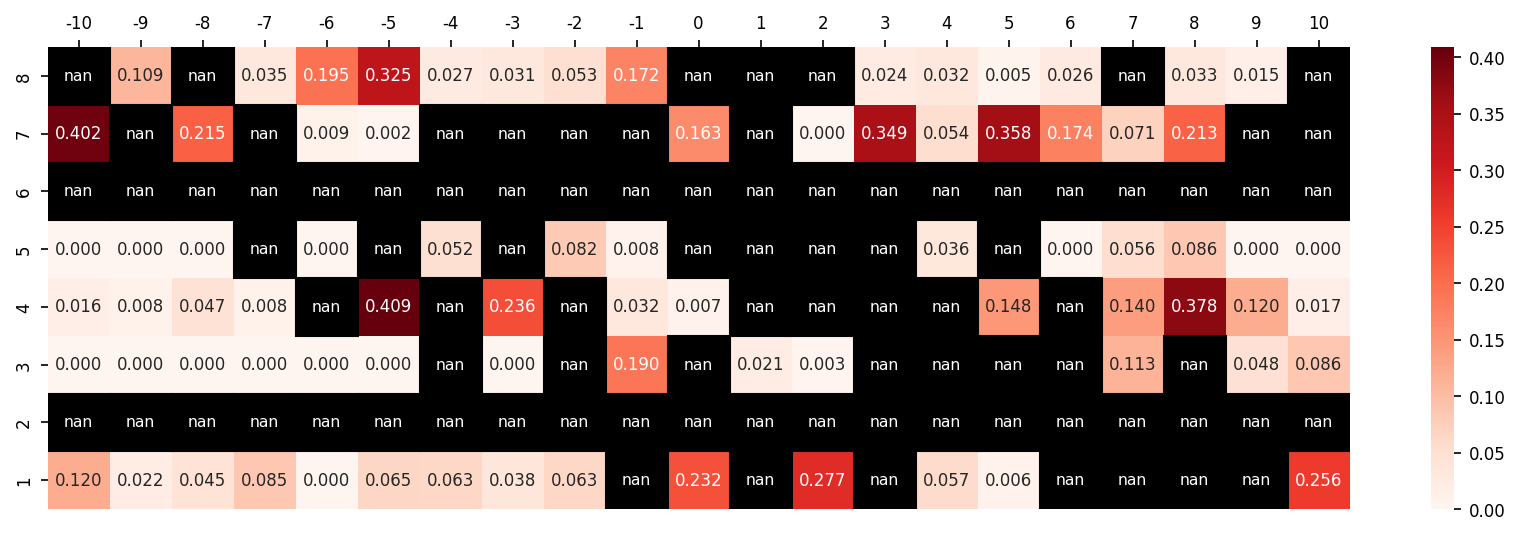

In [58]:
fig, ax = plt.subplots(figsize=(14,4),dpi=150)


mask = np.isnan(full_cos_list)

heatmap = sns.heatmap(full_cos_list,annot=True,fmt=".3f",annot_kws={"fontsize":8},ax=ax, mask=mask, cmap='Reds')
heatmap.collections[0].colorbar.ax.tick_params(labelsize=8)


# NaNを"nan"として表示
for i in range(full_cos_list.shape[0]):
    for j in range(full_cos_list.shape[1]):
        if np.isnan(full_cos_list[i, j]):
            cell = heatmap.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='black', edgecolor='none'))
            ax.text(j + 0.5, i + 0.5, 'nan', ha='center', va='center', color='white',fontsize=7.5)



# 目盛りの変更
plt.xticks(np.arange(21)+0.5, range(-10,11),fontsize=8)

# 横軸の目盛りを図の上に配置
plt.tick_params(axis='x', top=True, bottom=False, labeltop=True, labelbottom=False)

# 横軸の目盛り数値を上に配置
ax = plt.gca()
ax.xaxis.set_label_position('top')

plt.yticks(np.arange(len(full_cos_list))+0.5, range(len(full_cos_list),0,-1),fontsize=8)


fig.savefig("HeatMap.pdf", dpi=150)
plt.show()